   # 0.0. Imports & Aux Functions

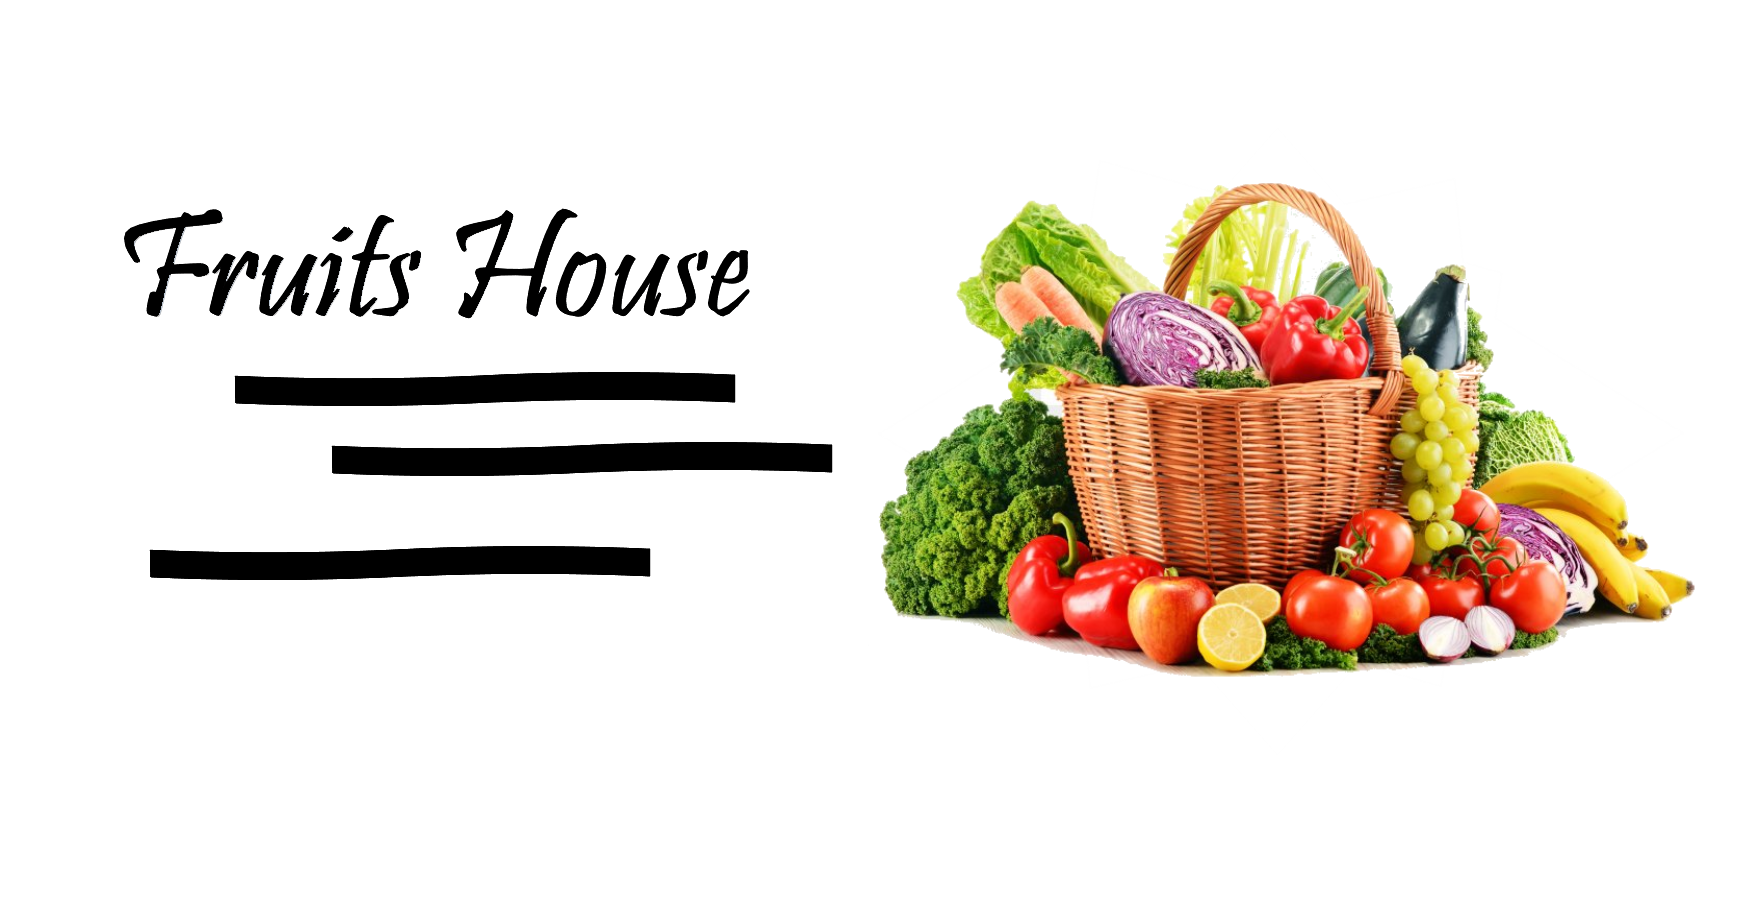

In [3]:
Image( '../img/logo1.png' )

In [144]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import Image

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import Precision
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation
from tensorflow.keras.layers.experimental.preprocessing import RandomZoom

import seaborn as sns

## 0.1. Aux Functions

In [142]:
plt.rcParams['figure.figsize'] = [20, 15]

def ext_label( img_list ):
    return img_list.split('/')[-2]

def img_transform( image, label):
    image = tf.io.read_file( image )
    image = tf.io.decode_jpeg( image )
    return image, label

def data_preparation( path, labels, train=True ):
    img_path = tf.convert_to_tensor( path )
    labels   = tf.convert_to_tensor( labels )
    df_img   = tf.data.Dataset.from_tensor_slices( img_path )
    df_label = tf.data.Dataset.from_tensor_slices( labels )
    dataset  = tf.data.Dataset.zip( ( df_img, df_label ) )
    dataset  = dataset.map( lambda image, label: img_transform( image, label ) )
    dataset  = dataset.map( lambda image, label: ( resizer( image ), label ), num_parallel_calls=autotune )
    dataset  = dataset.shuffle( 1000 )
    dataset  = dataset.batch( batch_size )
    
    if train:
        dataset = dataset.map( lambda image, label:( data_augmentation( image ), label ), num_parallel_calls=autotune  )
    
    dataset = dataset.repeat()
    
    return dataset

# 1.0. Load Dataset

In [51]:
df_train = Path( '../fruits-360/Training' )
df_test  = Path( '../fruits-360/Test' )

img_train = list( df_train.glob('*/*') )
img_train = list( map( lambda x: str(x), img_train ) )
img_train = [i.replace('\\', '/') for i in img_train] # Pure Path
img_train[200:202]

['../fruits-360/Training/Apple Braeburn/280_100.jpg',
 '../fruits-360/Training/Apple Braeburn/281_100.jpg']

In [113]:
labels_u = set( map( lambda x: ext_label(x), img_train ) )
labels_s = np.array( list( map(lambda x: ext_label(x), img_train ) ) )

print( f'Total Fruits for Training: {len(img_train)}\nTotal Unique Fruits Type: {len(labels_u)}' )

Total Fruits for Training: 67692
Total Unique Fruits Type: 131


# 2.0. Data Pre-Processing

## 2.1. Label Transformation

In [53]:
img_train_label = list( map( lambda x: ext_label(x), img_train ) ) # Label Extraction

le = LabelEncoder()
img_train_label = le.fit_transform( img_train_label ) # Label Encoder

img_train_label = tf.keras.utils.to_categorical( img_train_label )

In [56]:
print( f'Img Train Labels Encoding: {img_train_label}' )

Img Train Labels Encoding: [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


## 2.2. Split Dataset Training & Validation

In [57]:
X_train, X_valid, Y_train, Y_valid = train_test_split( img_train, img_train_label )

print( f'X Train: {X_train[10:11]}\nY Train: {Y_train[10:11]}\n\nX Train Shape: {len(X_train)}\nY Train Shape: {len(Y_train)}' )

X Train: ['../fruits-360/Training/Pepper Orange/r_284_100.jpg']
Y Train: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

X Train Shape: 50769
Y Train Shape: 50769


# 3.0. Data Preparation

In [129]:
resizer = tf.keras.Sequential( [tf.keras.layers.experimental.preprocessing.Resizing( 100, 100 ) ] )
data_augmentation = tf.keras.Sequential( [RandomFlip('horizontal'),
                                         RandomRotation(0.2),
                                         RandomZoom( height_factor = [-0.3, -0.2] ) ] )

In [128]:
batch_size = 32
autotune = tf.data.experimental.AUTOTUNE 

## 3.1. Create Tensorflow Dataset

In [136]:
dataset_train = data_preparation( X_train, Y_train )
image, label = next( iter( dataset_train ) )

print( f'Image Shape: {image.shape}\nLabel Shape: {label.shape}' )

Image Shape: (32, 100, 100, 3)
Label Shape: (32, 131)


In [139]:
dataset_valid = data_preparation( X_valid, Y_valid, train=False )
image, label  = next( iter( dataset_valid ) )

print( f'Image Shape: {image.shape}\nLabel Shape: {label.shape}' )

Image Shape: (32, 100, 100, 3)
Label Shape: (32, 131)


In [137]:
type( dataset_train )

tensorflow.python.data.ops.dataset_ops.RepeatDataset

# 4.0. Deep Learning Model

## 4.1. Model Head

In [145]:
model_pre = EfficientNetB3( input_shape=( 100, 100, 3 ), include_top=False )
model = tf.keras.Sequential( [model_pre,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dense( 131, activation='softmax' ) ] )

In [146]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 4, 4, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 131)               201347    
Total params: 10,984,882
Trainable params: 10,897,579
Non-trainable params: 87,303
_________________________________________________________________


## 4.2. Create Model

In [147]:
lr = 0.001
ep = 1e-07
beta1, beta2 = 0.9, 0.999

In [148]:
model.compile( optimizer=Adam( learning_rate=lr,
                               beta_1 = beta1, 
                               beta_2 = beta2,
                               epsilon= ep ),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy', Precision( name = 'precision' ), Recall( name = 'Recal' ) ] )

## 4.3. Model Training

In [150]:
history = model.fit( dataset_train,
                     steps_per_epoch = len( X_train ) // batch_size,
                     epochs = 1,
                     validation_data  = dataset_valid,
                     validation_steps = len( Y_train ) // batch_size )

1586/1586 [==============================] - 402s 233ms/step - loss: 0.2875 - accuracy: 0.9259 - precision: 0.9582 - Recal: 0.9037 - val_loss: 1.9203 - val_accuracy: 0.5341 - val_precision: 0.5988 - val_Recal: 0.4876


## 4.5. Early Stopping

In [153]:
model.layers[0].treinable = False

In [154]:
checkpoint = tf.keras.callbacks.ModelCheckpoint( '../modelo/deep_learning_model_01',
                                                 verbose = 1, 
                                                 save_best = True,
                                                 save_weights_only=True )

early_stopping = tf.keras.callbacks.EarlyStopping( patience=4 )

In [156]:
%%time
history = model.fit( dataset_train,
                     steps_per_epoch = len( X_train ) // batch_size,
                     epochs = 12,
                     validation_data  = dataset_valid,
                     validation_steps = len( Y_train ) // batch_size,
                     callbacks = [checkpoint, early_stopping] )

Epoch 1/12
1586/1586 [==============================] - 373s 231ms/step - loss: 0.0770 - accuracy: 0.9782 - precision: 0.9811 - Recal: 0.9756 - val_loss: 0.6439 - val_accuracy: 0.8351 - val_precision: 0.8503 - val_Recal: 0.8251

Epoch 00001: saving model to ../modelo\deep_learning_model_01
Epoch 2/12
1586/1586 [==============================] - 424s 266ms/step - loss: 0.0590 - accuracy: 0.9838 - precision: 0.9855 - Recal: 0.9820 - val_loss: 2.5872 - val_accuracy: 0.5380 - val_precision: 0.5766 - val_Recal: 0.5044

Epoch 00002: saving model to ../modelo\deep_learning_model_01
Epoch 3/12
1586/1586 [==============================] - 1066s 673ms/step - loss: 0.0447 - accuracy: 0.9875 - precision: 0.9887 - Recal: 0.9868 - val_loss: 1.4161 - val_accuracy: 0.6868 - val_precision: 0.7379 - val_Recal: 0.6560

Epoch 00003: saving model to ../modelo\deep_learning_model_01
Epoch 4/12
1586/1586 [==============================] - 1263s 797ms/step - loss: 0.0432 - accuracy: 0.9889 - precision: 0.9896